###**Andrew Renninger**
### Final

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Wrangling



We are going to use a tool called Earth Engine, which is maintained by Google requires a Google account.



In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=87bFi1fscw-P_G5XunaCe88URiM_gVxKntFEROrjdP0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/zQG1UPZAa3e7z1skf3OKYj8iS-m0rUzLNgWyKb07rop_DXYowFp7JPg

Successfully saved authorization token.


In [4]:
import tensorflow as tf
import folium

print(tf.__version__)
print(folium.__version__)

2.2.0-rc4
0.8.3


These are some global parameters—the first chunk for saving data and the following chunks for selecting relevant data. 

In [0]:
FOLDER = 'final'
TRAINING_BASE = 'training'
EVAL_BASE = 'testing'

opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']

BANDS = opticalBands + thermalBands

RESPONSE = ['landcover', 'impervious']

#### Predictor variables

To process the spectral bands, the Earth Engine guide comes with this function, which screens images for cloud cover and removes those pixels. We also adjust the thermal bands, which are given in Kelvin.  

In [0]:
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
      image.select(thermalBands).divide(10).clamp(273.15, 373.15)
      .subtract(273.15).divide(100)).updateMask(mask)

Here we use Earth Engine to call the image collections we need: Landsat images and topography (Shuttle Radar Topography Mission, or SRTM).

In [7]:
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
srtm = ee.Image('USGS/SRTMGL1_003')

winter = ee.Filter.calendarRange(11, 2, 'month')
summer = ee.Filter.calendarRange(5, 8, 'month')

winterimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(winter).map(maskL8sr).median()
summerimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(summer).map(maskL8sr).median()

mapid = winterimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (summer)',
  ).add_to(map)

mapid = winterimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (summer)',
  ).add_to(map)

map.add_child(folium.LayerControl())
map


#### Response varibales

For the response variables, we grab the National Land Cover Database, or NLCD, and select Landcover and impervious. Note that these and the above images do occupy little memory. A benefit of using Earth Engine in data collection when we begin with large datasets and need to select subsets from them is that we can leave most of the data in the cloud. 

In [8]:
lc = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
lc = lc.float()

im = ee.Image('USGS/NLCD/NLCD2016').select('impervious')
im = im.divide(100).float()

mapid = im.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='nlcd impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Composite

In [0]:
light1 = winterimage.select(BANDS)
light2 = summerimage.select(BANDS)

slope = ee.Terrain.slope(srtm) 

nlcd = lc.addBands(im)

composite = nlcd.addBands([slope, light1, light2])

In [10]:
mapid = composite.getMapId({'bands': ['slope'], 'min': 0, 'max': 50})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map

All of these images return different types, so we need to unify them as floating point numbers for export. 

In [0]:
composite = composite.float()

#### Areas of interest

In [12]:
trainingPolys = ee.FeatureCollection('users/asrenninger/training')
evalPolys = ee.FeatureCollection('users/asrenninger/testing')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['cyan', 'magenta']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

In [0]:
for g in range(trainingPolys.size().getInfo()):
  desc = TRAINING_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(trainingPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

In [0]:
for g in range(evalPolys.size().getInfo()):
  desc = EVAL_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(evalPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

## Modelling

### Convolutional

In [4]:
!pip install tifffile

     |████████████████████████████████| 133kB 2.5MB/s 
     |████████████████████████████████| 18.1MB 67.1MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Specifying the model

In [6]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#### Testing on one

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

In [17]:
img = tiff.imread(path)
img.shape

(6410, 6690, 21)

In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

In [0]:
import matplotlib
import matplotlib.pyplot as plt

(-0.5, 6689.5, 6409.5, -0.5)

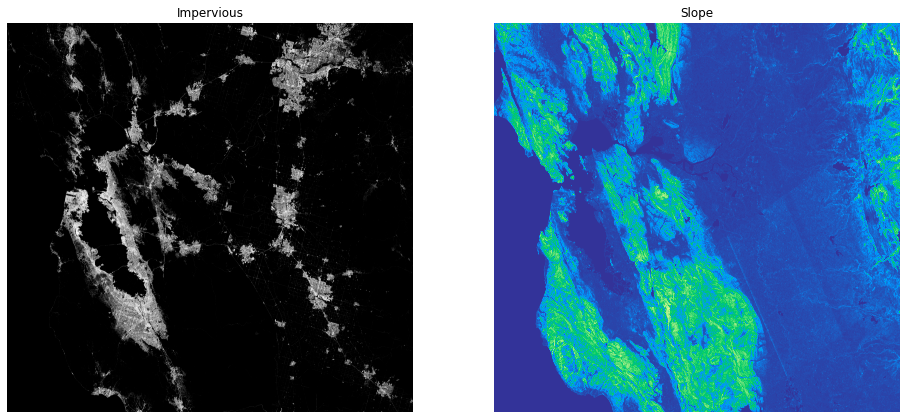

In [21]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(img[:, :, 1], cmap = 'gray')
axs[1].imshow(img[:, :, 2], cmap = 'terrain')

axs[0].set_title('Impervious')
axs[1].set_title('Slope')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

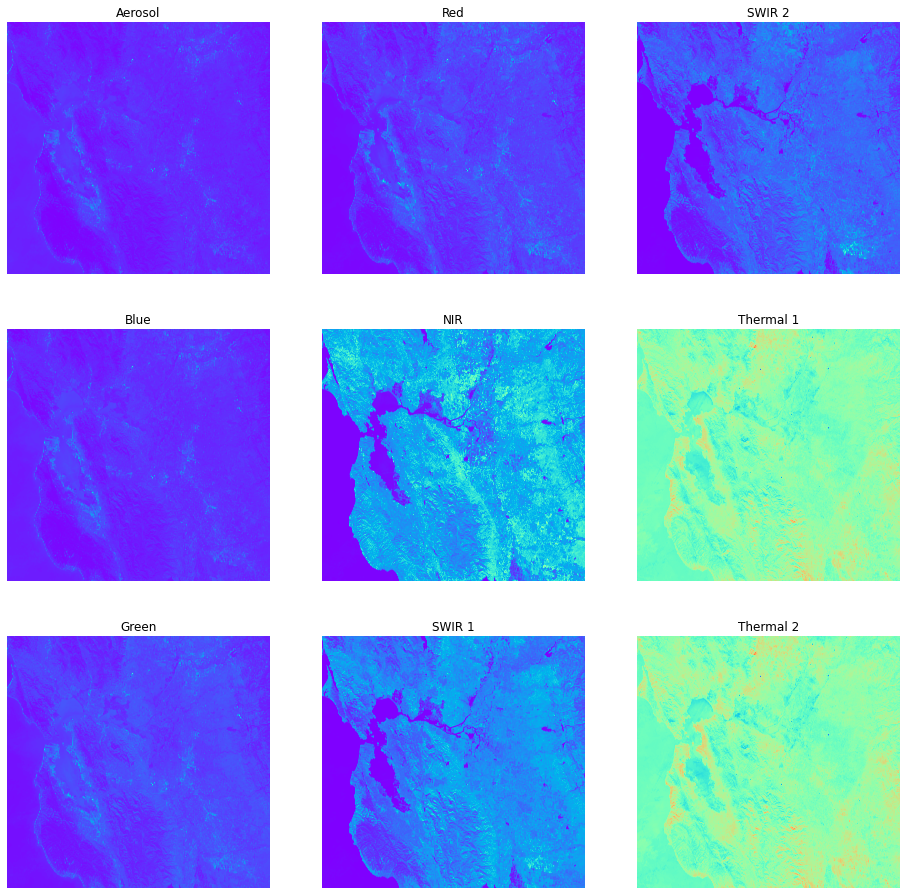

In [22]:
fig, axs = plt.subplots(3, 3, figsize = [16, 16])

opticalBands = ['Aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR 1', 'SWIR 2']
thermalBands = ['Thermal 1', 'Thermal 2']

BANDS = opticalBands + thermalBands

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      axs[j, i].axis('off')
      axs[j, i].imshow(img[:,:, slot + 3], cmap = 'rainbow')
      axs[j, i].set_title('{}'.format(BANDS[slot]))
        
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
from sklearn.feature_extraction import image

In [24]:
patches = image.extract_patches_2d(img, (128, 128), max_patches = 1000, random_state = 42)
patches.shape

(1000, 128, 128, 21)

In [30]:
masks = patches[:, :, :, :1]
masks.shape

(1000, 128, 128, 1)

In [0]:
impervious = patches[:, :, :, 1]

In [0]:
flat = masks.flatten()

flat = np.where((flat < 21) | (flat > 24), 0, flat)
flat = np.where((flat > 20) & (flat < 25), 1, flat)

square = flat.reshape(masks.shape)

In [32]:
patches = patches[:, :, :, 2:]
patches.shape

(1000, 128, 128, 19)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(patches, square, test_size = 0.4, random_state = 42)

In [0]:
from numpy import random

Text(0.5, 1.0, 'Landcover')

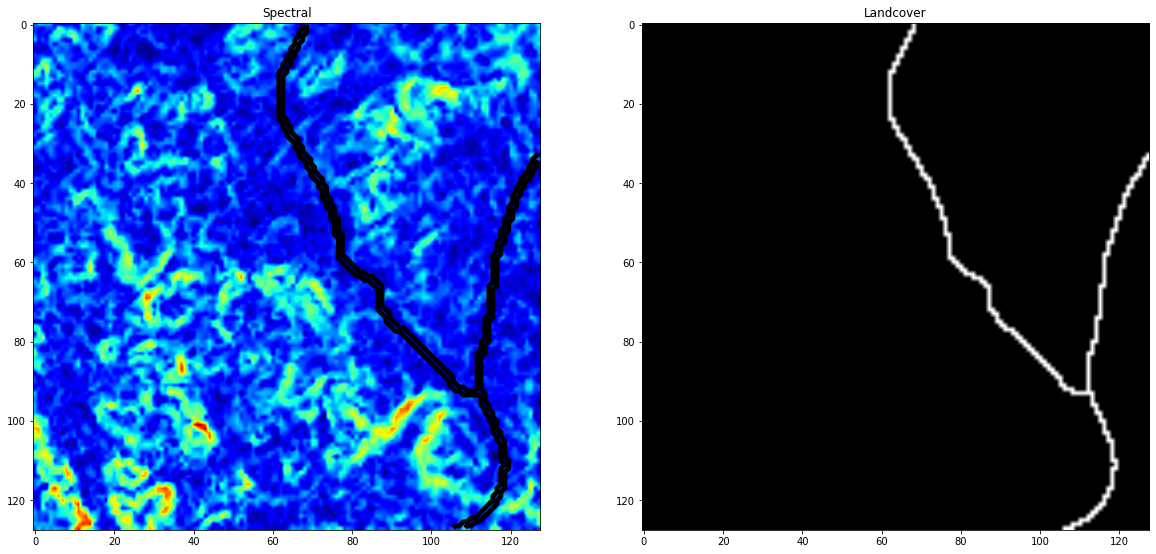

In [36]:
idx = random.randint(0, len(X_train))
has_mask = y_train[idx].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[idx, ..., 0], cmap = 'jet', interpolation = 'bilinear')
if has_mask: 
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Spectral')

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Landcover')

In [0]:
input_img = Input((128, 128, 19), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [0]:
model.summary()

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-conv-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [43]:
results = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    epochs = 100, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid))

Train on 600 samples, validate on 400 samples
Epoch 1/100
600/600 [==============================] - 11s 19ms/step - loss: 0.6117 - accuracy: 0.6788 - val_loss: 45.5448 - val_accuracy: 0.2687

Epoch 00001: val_loss improved from inf to 45.54478, saving model to model-lc-conv-test.h5
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4974 - accuracy: 0.8253 - val_loss: 4.8137 - val_accuracy: 0.6493

Epoch 00002: val_loss improved from 45.54478 to 4.81370, saving model to model-lc-conv-test.h5
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4460 - accuracy: 0.8457 - val_loss: 2.9146 - val_accuracy: 0.6240

Epoch 00003: val_loss improved from 4.81370 to 2.91457, saving model to model-lc-conv-test.h5
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.3904 - accuracy: 0.8819 - val_loss: 2.0444 - val_accuracy: 0.5486

Epoch 00004: val_loss improved from 2.91457 to 2.04438, saving model to model-lc-conv-test.h5
E

In [44]:
score = model.evaluate(X_valid, y_valid, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.19288437128067015
Test accuracy:  0.9367448687553406


#### Testing on all

In [0]:
import gc
gc.enable()

In [0]:
import numpy as np
import tifffile as tiff

from sklearn.feature_extraction import image

In [12]:
directory = '/content/drive/My Drive/final/patches'

data = np.empty((0, 128, 128, 21))

for i in np.arange(0, 4):
  file = ("/training_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  patches = image.extract_patches_2d(img, (128, 128), max_patches = 400, random_state = 42)

  data = np.concatenate((data, patches))

/training_comp_0.tif
/training_comp_1.tif
/training_comp_2.tif
/training_comp_3.tif


In [13]:
for i in np.arange(0, 4):
  file = ("/testing_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  patches = image.extract_patches_2d(img, (128, 128), max_patches = 400, random_state = 42)

  data = np.concatenate((data, patches))

/testing_comp_0.tif
/testing_comp_1.tif
/testing_comp_2.tif
/testing_comp_3.tif


In [0]:
img = "nothing"

In [15]:
patches = data
patches.shape

(3200, 128, 128, 21)

In [16]:
gc.collect()

358

In [17]:
masks = patches[:, :, :, :1]
masks.shape

(3200, 128, 128, 1)

In [0]:
flat = masks.flatten()

flat = np.where((flat < 21) | (flat > 24), 0, flat)
flat = np.where((flat > 20) & (flat < 25), 1, flat)

masks = flat.reshape(masks.shape)

In [19]:
patches = patches[:, :, :, 2:]
patches.shape

(3200, 128, 128, 19)

In [0]:
flat = "nothing"

In [21]:
gc.collect()

0

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(patches, masks, test_size = 0.4, random_state = 42)

In [0]:
input_img = Input((128, 128, 19), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-conv.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    epochs = 100, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid))

Train on 1920 samples, validate on 1280 samples
Epoch 1/100
1920/1920 [==============================] - 12s 6ms/step - loss: 0.4721 - accuracy: 0.7926 - val_loss: 0.4848 - val_accuracy: 0.7867

Epoch 00001: val_loss improved from inf to 0.48481, saving model to model-lc-conv.h5
Epoch 2/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3574 - accuracy: 0.8612 - val_loss: 0.5292 - val_accuracy: 0.7912

Epoch 00002: val_loss did not improve from 0.48481
Epoch 3/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3335 - accuracy: 0.8701 - val_loss: 0.3816 - val_accuracy: 0.8380

Epoch 00003: val_loss improved from 0.48481 to 0.38158, saving model to model-lc-conv.h5
Epoch 4/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3170 - accuracy: 0.8765 - val_loss: 0.4307 - val_accuracy: 0.7993

Epoch 00004: val_loss did not improve from 0.38158
Epoch 5/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3032 - a

In [0]:
score = model.evaluate(X_valid, y_valid, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.2059366602450609
Test accuracy:  0.9258022308349609


In [0]:
model.save_weights(directory + '/checkpoint_conv')

In [0]:
model.load_weights(directory + '/checkpoint_conv')

In [0]:
y_pred = model.predict(X_valid)

In [0]:
import matplotlib
import matplotlib.pyplot as plt

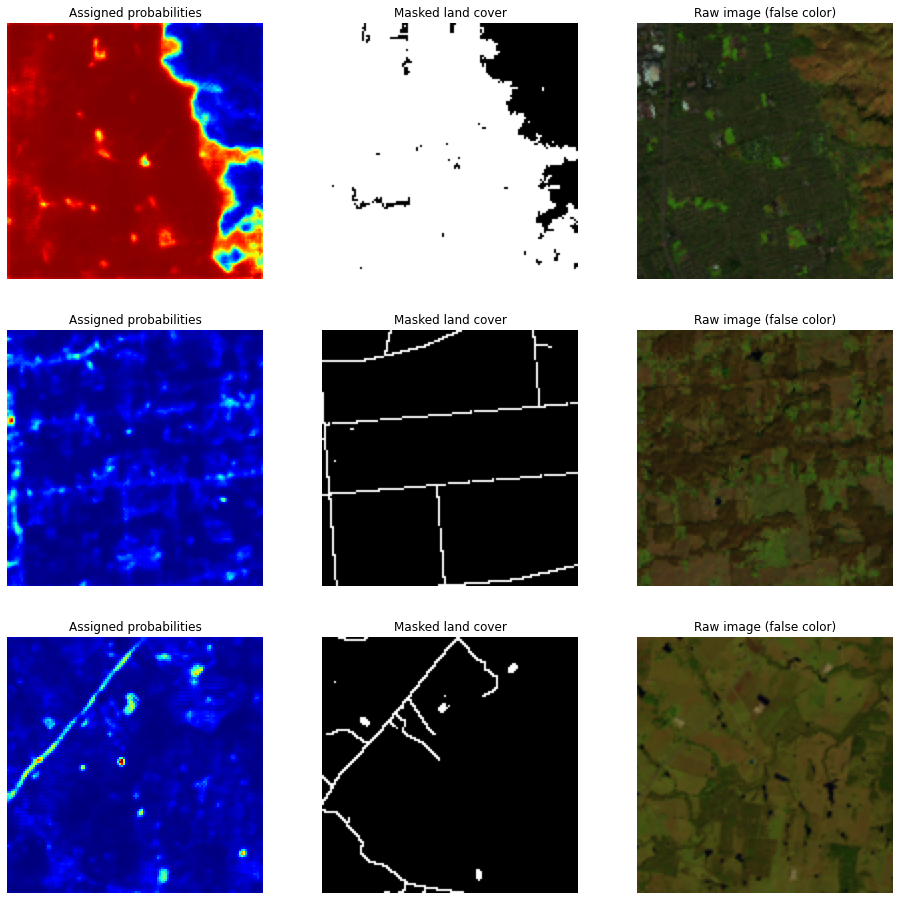

In [40]:
idx = np.random.randint(1, y_valid.shape[0], 3)

fig, axs = plt.subplots(3, 3, figsize = [16, 16])

for i in np.arange(0, 3):
      slot = i
      img = y_pred[idx[slot]][:, :, 0]
      axs[i, 0].set_title("Assigned probabilities")
      axs[i, 0].imshow(img, cmap = 'jet')
      axs[i, 0].set_axis_off()
      img = y_valid[idx[slot]][:, :, 0]
      axs[i, 1].set_title("Masked land cover")
      axs[i, 1].imshow(img, cmap = 'gray')
      axs[i, 1].set_axis_off()
      img = X_valid[idx[slot]][:, :, (6, 5, 3)]
      axs[i, 2].set_title("Raw image (false color)")
      axs[i, 2].imshow(img)
      axs[i, 2].set_axis_off()

plt.show()

In [0]:
y_pred = model.predict(X_valid, verbose=1) > 0.5
y_pred = y_pred.astype('uint8')

y_real = y_valid.flatten()
y_pred = y_pred.flatten()

In [0]:
from sklearn.metrics import confusion_matrix

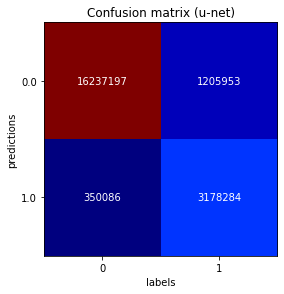

In [44]:
cm = confusion_matrix(y_pred, y_real)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'jet')

ax.set_xticks(np.arange(len(np.unique(y_pred))))
ax.set_yticks(np.arange(len(np.unique(y_real))))
ax.set_xticklabels(np.unique(y_pred))
ax.set_yticklabels(np.unique(y_real))

for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_real))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix (u-net)")
fig.tight_layout()

plt.xlabel('labels')
plt.ylabel('predictions')
plt.show()

In [0]:
import pandas as pd

In [0]:
pd.DataFrame(results.history).to_csv(directory + "/history_conv.csv")

### Conventional

In [1]:
!pip install tifffile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Specifiying the model

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCH = 100
BATCH = 32 

As is abundantly clear from the images, the classes are not separable linearly, so hidden layers are required. 

In [0]:
def get_mlp():
  model = Sequential()
  
  model.add(Dense(128, activation='relu', input_shape=(19,)))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))

  return model

#### Testing on one

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

In [8]:
img = tiff.imread(path)
print(img.shape)

(6410, 6690, 21)

In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

In [14]:
resp = img[:, :, 0].flatten()

resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

pred = np.zeros([resp.shape[0], 19])
print(pred.shape)

(42882900,)
(42882900, 19)


In [15]:
np.unique(resp)

array([0., 1.], dtype=float32)

In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 2]

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

In [0]:
idx = np.random.randint(0, len(resp), 100000)

resp = resp[idx]
pred = pred[idx, :]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-mlp-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
model = get_mlp()
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [40]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test))

Train on 50000 samples, validate on 50000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 206us/step - loss: 0.2660 - accuracy: 0.9059 - val_loss: 0.2335 - val_accuracy: 0.9184

Epoch 00001: val_loss improved from inf to 0.23352, saving model to model-lc-mlp-test.h5
Epoch 2/100
50000/50000 [==============================] - 10s 203us/step - loss: 0.2275 - accuracy: 0.9219 - val_loss: 0.2142 - val_accuracy: 0.9227

Epoch 00002: val_loss improved from 0.23352 to 0.21419, saving model to model-lc-mlp-test.h5
Epoch 3/100
50000/50000 [==============================] - 10s 204us/step - loss: 0.2167 - accuracy: 0.9250 - val_loss: 0.2125 - val_accuracy: 0.9251

Epoch 00003: val_loss improved from 0.21419 to 0.21252, saving model to model-lc-mlp-test.h5
Epoch 4/100
50000/50000 [==============================] - 10s 202us/step - loss: 0.2110 - accuracy: 0.9271 - val_loss: 0.2045 - val_accuracy: 0.9280

Epoch 00004: val_loss improved from 0.21252 to 0.20454, saving model to

In [41]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.17618987893104554
Test accuracy:  0.9367799758911133


#### Testing on all

In [0]:
from sklearn import preprocessing

In [44]:
directory = '/content/drive/My Drive/final/patches'

data = np.empty((0, 150, 21))

for i in np.arange(0, 4):
  file = ("/training_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  data = np.concatenate((data, img))

/training_comp_0.tif
/training_comp_1.tif
/training_comp_2.tif
/training_comp_3.tif


In [45]:
for i in np.arange(0, 4):
  file = ("/testing_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  data = np.concatenate((data, img))

/testing_comp_0.tif
/testing_comp_1.tif
/testing_comp_2.tif
/testing_comp_3.tif


In [46]:
print(data.shape)

(1200, 150, 21)


In [47]:
resp = data[:, :, 0].flatten()

resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

pred = np.zeros([resp.shape[0], 20])
print(pred.shape)

(180000,)
(180000, 20)


In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  temp = data[:, :, i + 1]

  scaler = preprocessing.StandardScaler().fit(temp)
  scaled = scaler.transform(temp)
  pred[:, i] = scaled.flatten()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [0]:
imp_train = X_train[:, 0]
imp_test = X_test[:, 0]

X_train = X_train[:, 1:]
X_test = X_test[:, 1:]

In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-mlp-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
model = get_mlp()
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [63]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test))

Train on 90000 samples, validate on 90000 samples
Epoch 1/100
90000/90000 [==============================] - 20s 219us/step - loss: 0.2939 - accuracy: 0.8900 - val_loss: 0.2734 - val_accuracy: 0.8991

Epoch 00001: val_loss improved from inf to 0.27341, saving model to model-lc-mlp-test.h5
Epoch 2/100
90000/90000 [==============================] - 20s 217us/step - loss: 0.2642 - accuracy: 0.9026 - val_loss: 0.2637 - val_accuracy: 0.9048

Epoch 00002: val_loss improved from 0.27341 to 0.26373, saving model to model-lc-mlp-test.h5
Epoch 3/100
90000/90000 [==============================] - 19s 210us/step - loss: 0.2573 - accuracy: 0.9054 - val_loss: 0.2574 - val_accuracy: 0.9048

Epoch 00003: val_loss improved from 0.26373 to 0.25744, saving model to model-lc-mlp-test.h5
Epoch 4/100
90000/90000 [==============================] - 19s 207us/step - loss: 0.2540 - accuracy: 0.9059 - val_loss: 0.2516 - val_accuracy: 0.9075

Epoch 00004: val_loss improved from 0.25744 to 0.25161, saving model to

In [64]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.22915414777464338
Test accuracy:  0.9152777791023254


In [0]:
model.save_weights(directory + '/checkpoint_mlp')

In [0]:
model.load_weights(directory + '/checkpoint_mlp')

In [0]:
import matplotlib
import matplotlib.pyplot as plt

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

In [108]:
img = tiff.imread(path)
print(img.shape)

(6410, 6690, 21)


In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

In [112]:
resp = img[:, :, 1]
flat = resp.flatten()
print(flat.shape)

pred = np.zeros([flat.shape[0], 19])
print(pred.shape)

(42882900,)
(42882900, 19)


In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 2]

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

In [0]:
y_pred = model.predict(pred, verbose = 1)
y_pred = y_pred[:, 1].reshape(resp.shape)

 7424000/42882900 [====>.........................] - ETA: 23:57

In [0]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(resp, cmap = 'gray')
axs[1].imshow(y_pred, cmap = 'jet')

axs[0].set_title('Impervious')
axs[1].set_title('predictions')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [85]:
y_pred = model.predict_classes(X_test, verbose = 1)
y_real = np.argmax(y_test, axis = 1)

90000/90000 [==============================] - 4s 40us/step


In [0]:
from sklearn.metrics import confusion_matrix

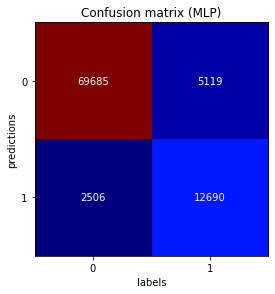

In [89]:
cm = confusion_matrix(y_pred, y_real)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'jet')

ax.set_xticks(np.arange(len(np.unique(y_pred))))
ax.set_yticks(np.arange(len(np.unique(y_real))))
ax.set_xticklabels(np.unique(y_pred))
ax.set_yticklabels(np.unique(y_real))

for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_real))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix (MLP)")
fig.tight_layout()

plt.xlabel('labels')
plt.ylabel('predictions')
plt.show()

90000/90000 [==============================] - 4s 39us/step


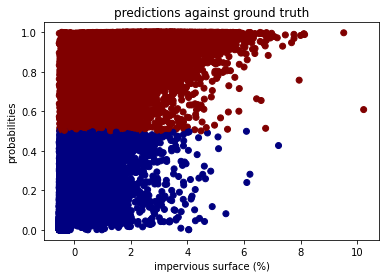

In [115]:
fig, ax = plt.subplots()

probs = model.predict(X_test, verbose = 1)
color = model.predict_classes(X_test, verbose = 1)
probs = probs[:, 1]

ax.scatter(imp_test, probs, c = color, cmap = 'jet')

ax.set_title("predictions against ground truth")

plt.xlabel('impervious surface (%)')
plt.ylabel('probabilities')
plt.show()

In [0]:
import pandas as pd

In [0]:
pd.DataFrame(history.history).to_csv(directory + "/history_conv.csv")

### Further improvement

#### Preprocessing

In [0]:
import cv2
from PIL import Image, ImageFilter

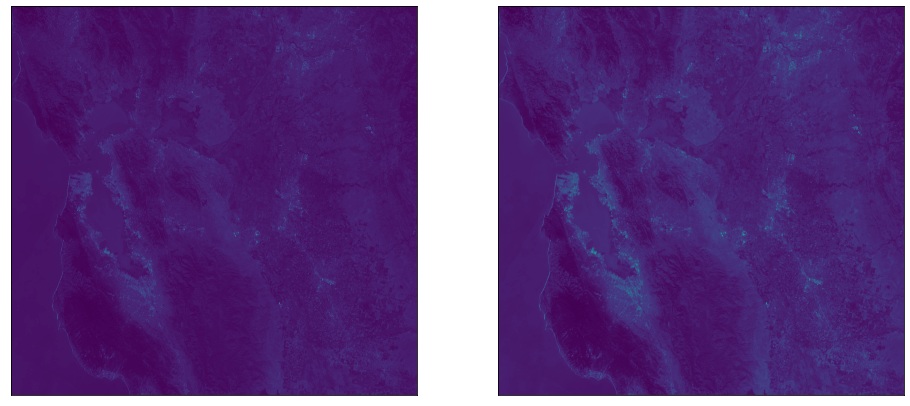

In [0]:
kernel = 9 

old_image = img[:, :, 2]
new_image = cv2.blur(old_image, (kernel, kernel))

plt.figure(figsize=(16, 16))

plt.subplot(121), plt.imshow(old_image)
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(new_image)
plt.xticks([]), plt.yticks([])

plt.show()

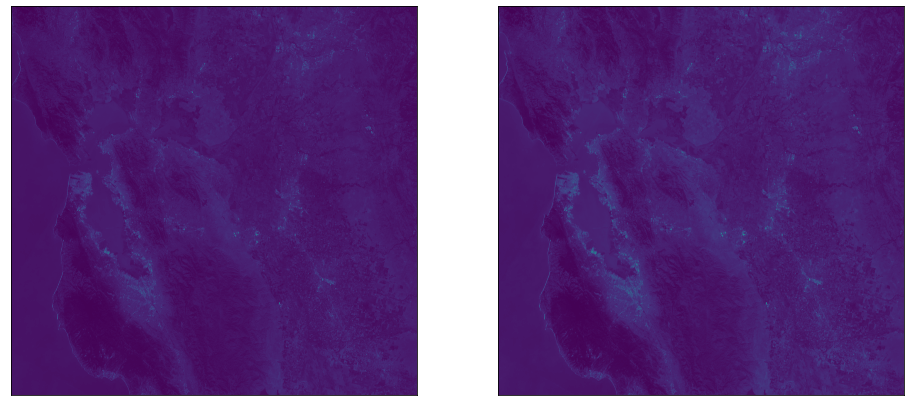

In [0]:
kernel = 9 

old_image = img[:, :, 2]
new_image = new_image = cv2.bilateralFilter(old_image, 9, 9, 9)

plt.figure(figsize=(16, 16))

plt.subplot(121), plt.imshow(old_image)
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(new_image)
plt.xticks([]), plt.yticks([])

plt.show()

Patch as input, pixel as output / 
Semantic segmentation (U-Net) / 
Image in-Image out /
Existing model /